In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

plt.style.use('default')


pd.set_option('display.max_columns', None)


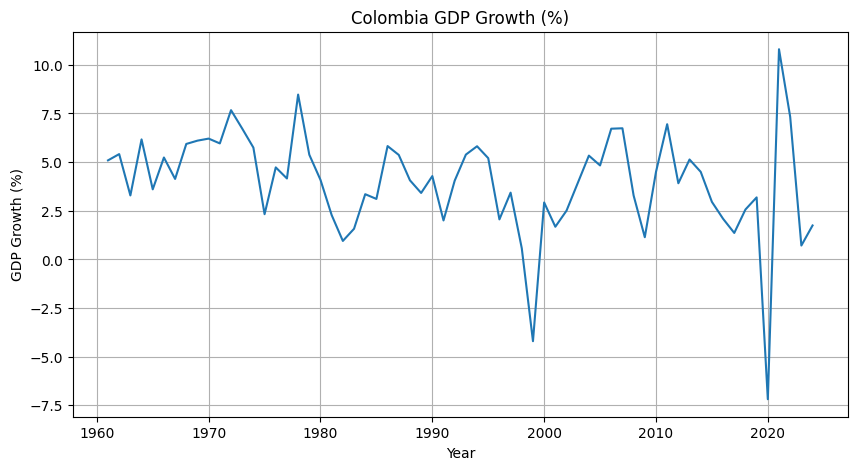

In [12]:
import requests
import pandas as pd


url = "https://api.worldbank.org/v2/country/COL/indicator/NY.GDP.MKTP.KD.ZG?format=json&per_page=200"

response = requests.get(url).json()


data_list = response[1]

df = pd.DataFrame(data_list)


gdp = df[["date", "value"]].rename(columns={"value": "gdp_growth"})


gdp["date"] = gdp["date"].astype(int)
gdp = gdp.dropna().sort_values("date")

gdp.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(gdp["date"], gdp["gdp_growth"])
plt.title("Colombia GDP Growth (%)")
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
plt.grid(True)
plt.show()



In [13]:

inflation_url = "https://api.worldbank.org/v2/country/COL/indicator/FP.CPI.TOTL.ZG?format=json&per_page=200"

inflation_raw = requests.get(inflation_url).json()
inflation_df = pd.DataFrame(inflation_raw[1])

inflation = inflation_df[["date", "value"]].rename(columns={
    "value": "inflation"
})

inflation["date"] = inflation["date"].astype(int)
inflation = inflation.dropna().sort_values("date")

inflation.head()


,date,inflation
53,1971,11.940262
52,1972,12.444459
51,1973,22.529649
50,1974,23.870957
49,1975,23.437503


In [14]:

fdi_url = "https://api.worldbank.org/v2/country/COL/indicator/BX.KLT.DINV.WD.GD.ZS?format=json&per_page=200"

fdi_raw = requests.get(fdi_url).json()
fdi_df = pd.DataFrame(fdi_raw[1])

fdi = fdi_df[["date", "value"]].rename(columns={
    "value": "fdi_percent_gdp"
})

fdi["date"] = fdi["date"].astype(int)
fdi = fdi.dropna().sort_values("date")

fdi.head()


,date,fdi_percent_gdp
54,1970,0.597358
53,1971,0.551484
52,1972,0.212851
51,1973,0.231128
50,1974,0.330555


In [15]:

remittances_url = "https://api.worldbank.org/v2/country/COL/indicator/BX.TRF.PWKR.DT.GD.ZS?format=json&per_page=200"

rem_raw = requests.get(remittances_url).json()
rem_df = pd.DataFrame(rem_raw[1])

remittances = rem_df[["date", "value"]].rename(columns={
    "value": "fx_activity_proxy"
})

remittances["date"] = remittances["date"].astype(int)
remittances = remittances.dropna().sort_values("date")

remittances.head()


,date,fx_activity_proxy
54,1970,0.361193
53,1971,0.282155
52,1972,0.262934
51,1973,0.288910
50,1974,0.291666


In [8]:


merged = gdp.merge(inflation, on="date", how="inner") \
            .merge(fdi, on="date", how="inner") \
            .merge(remittances, on="date", how="inner")

merged = merged.rename(columns={"date": "year"})

merged.head(10)


,year,gdp_growth,inflation,fdi_percent_gdp,fx_activity_proxy
0,1971,5.960728,11.940262,0.551484,0.282155
1,1972,7.669148,12.444459,0.212851,0.262934
2,1973,6.722955,22.529649,0.231128,0.288910
3,1974,5.745757,23.870957,0.330555,0.291666
4,1975,2.323255,23.437503,0.282998,0.175591
5,1976,4.728369,19.831225,0.162958,0.332434
6,1977,4.158505,33.802818,0.333830,0.419735
7,1978,8.469901,17.763159,0.459948,0.325918
8,1979,5.379119,24.134076,0.454539,0.361484
9,1980,4.087354,26.552653,0.470462,0.317358


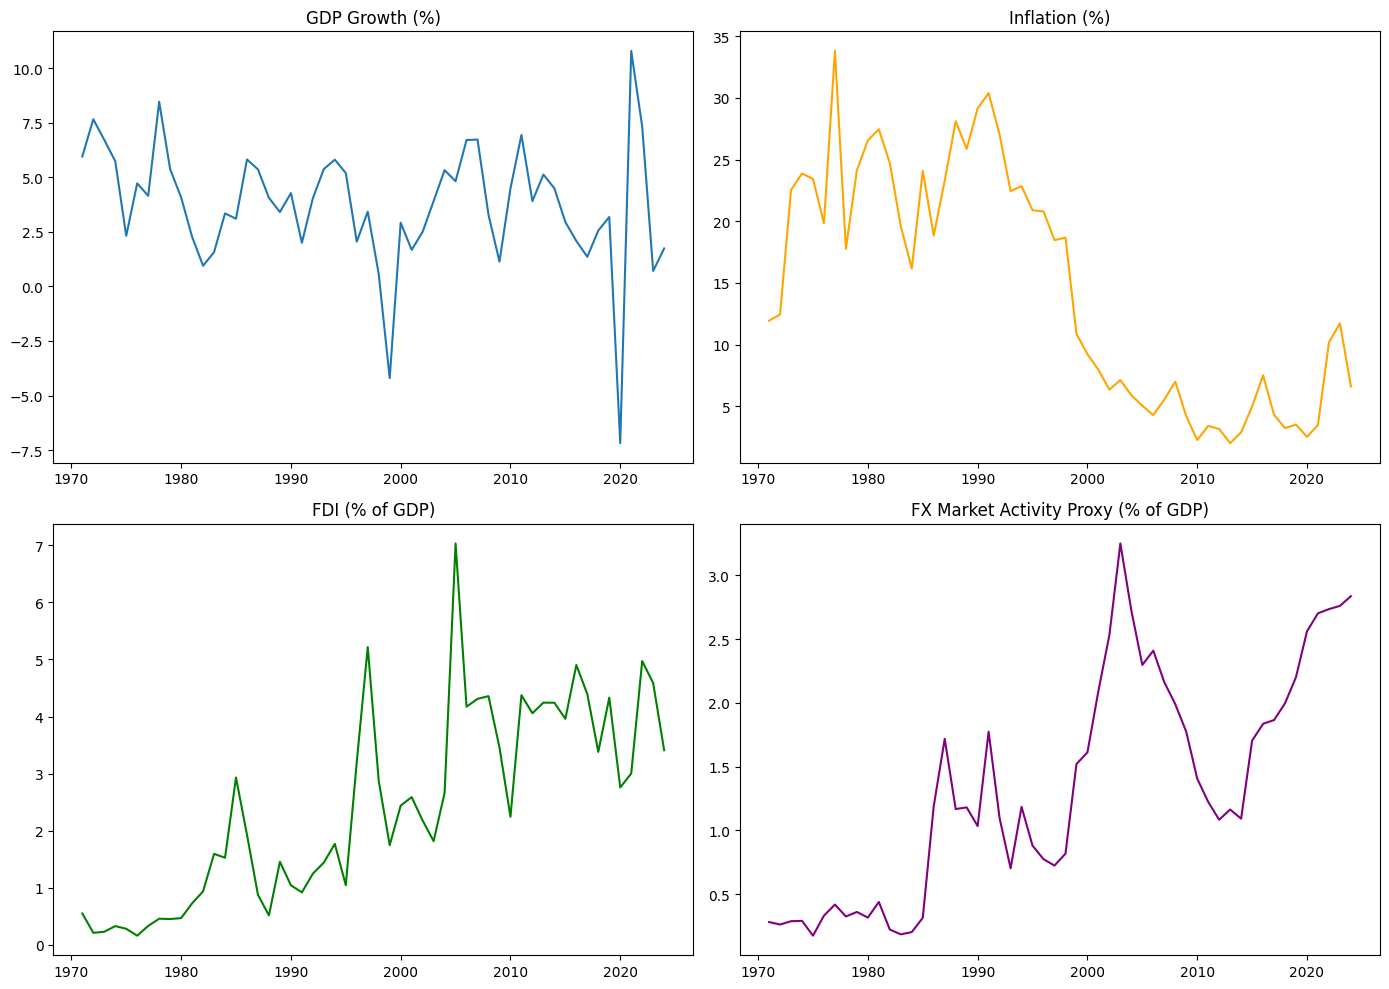

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

axs[0,0].plot(merged["year"], merged["gdp_growth"])
axs[0,0].set_title("GDP Growth (%)")

axs[0,1].plot(merged["year"], merged["inflation"], color="orange")
axs[0,1].set_title("Inflation (%)")

axs[1,0].plot(merged["year"], merged["fdi_percent_gdp"], color="green")
axs[1,0].set_title("FDI (% of GDP)")

axs[1,1].plot(merged["year"], merged["fx_activity_proxy"], color="purple")
axs[1,1].set_title("FX Market Activity Proxy (% of GDP)")

plt.tight_layout()
plt.show()


In [17]:
import statsmodels.api as sm

df_reg = merged.dropna()

X = df_reg[["inflation", "fdi_percent_gdp", "fx_activity_proxy"]]
X = sm.add_constant(X)

y = df_reg["gdp_growth"]

model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gdp_growth   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.3450
Date:                Wed, 26 Nov 2025   Prob (F-statistic):              0.793
Time:                        05:34:17   Log-Likelihood:                -131.90
No. Observations:                  54   AIC:                             271.8
Df Residuals:                      50   BIC:                             279.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.9807      1.838      2.710      0.009       1.289       8.672
inflation            -0.0238      0.064     -0.374      0.710      -0.152       0.104
fdi_percent_gdp      -0.0930      0.343     -0.271      0.788      -0.783       0.597
fx_activity_proxy    -0.4834      0.605     -0.799      0.428      -1.699       0.732
==============================================================================
Omnibus:                       18.440   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.476
Skew:                          -0.946   Prob(JB):                     4.42e-09
Kurtosis:                       6.677   Cond. No.                         82.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""